# Population Level Homogenous Mixing Epidemic Models

Susceptible-Infected-Removed (SIR) models make up the core of stochastic epidemic modeling. The simplest case of the model proposes that an population (of size $N$) transitions through three stages. Individuals start in the susceptible stage (unless they are part of the initial infected subset). As a result of interacting with the infected individuals in a population, a susceptible member transitions to the infected stage at a rate $\beta$. Once infected, these members of the population contribute to the total infectious pressure, infecting other susceptibles or they become removed (recovered - and assumed to be immune, or die) at a rate $\gamma$. 

In this document, we look at performing Bayesian inference on these models with the goal of *correctly* estimating the rates $(\beta, \gamma)$. Let's first simulate an epidemic using the Gillespie algorithm which is used to generate a potential trajectory of a stochastic process given some rates. 

In [29]:
# preamble - load all packages 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from scipy import stats

sns.set()

In [30]:
def sir1(beta, gamma, S0, I0, R0):
    # initial values
    S = S0
    I = I0
    R = R0
    N = S0 + I0 + R0
    t = 0

    # keep track of time epidemic state
    accum = [(t, S, I, R)]

    # simulate until epidemic ends
    while True:

        # 1. calculate rates
        si_rate = beta * S * I / (S + I + R)
        ir_rate = gamma * I
        total_rate = si_rate + ir_rate

        # exit condition
        if total_rate == 0.0:
            break

        # 2. sample next event (event is a transition from S -> I or I -> R)
        tstar = np.random.exponential(1 / total_rate)

        t += tstar

        # 3. sample type of even (here we choose between S -> I or I -> R - exclusive
        if np.random.uniform() < si_rate / total_rate:
            S -= 1
            I += 1
            R = R  # add 0
        else:
            S = S  # add 0
            I -= 1
            R += 1

        # 4. Keep track of progress
        accum.append((t, S, I, R))

    # format for output
    results = np.array(accum)
    return dict(t=results[:, 0],
                S=results[:, 1],
                I=results[:, 2],
                R=results[:, 3])

In [31]:
epi = pd.DataFrame(sir1(beta=0.3, gamma=0.14, S0=999, I0=1, R0=0))

In [32]:
epi.tail()

,t,S,I,R
1725,75.785358,136.0,2.0,862.0
1726,79.134478,135.0,3.0,862.0
1727,85.616531,135.0,2.0,863.0
1728,90.555705,135.0,1.0,864.0
1729,97.471327,135.0,0.0,865.0


<AxesSubplot:title={'center':'Simulated Epidemic: beta = 0.3, gamma = 0.14'}>

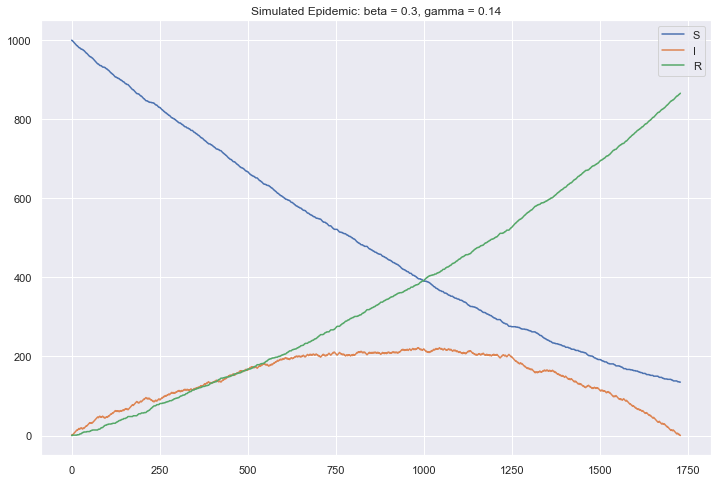

In [33]:
# plot the respective curves: 
epi.loc[:,'S':'R'].plot(figsize = (12,8), title = 'Simulated Epidemic: beta = 0.3, gamma = 0.14')

## Likelihood Construction 

Based on the Gillespie algorithm used in the ```sir1``` function, we can see that the dataset is an exponential random variable with the rate depending on the number of infected and susceptible individuals at each time stamp. We can write this out in the following way: 
\begin{equation}
    t^\star_i \sim exp(\beta \frac{ S_i I_i}{N} + \gamma I_i)
\end{equation}
In this model, there are 2 types of events that can happen. The first is a transition event $S \rightarrow I$ at a rate $\beta$ and the second is a transition event $I \rightarrow R$ at a rate $\gamma$. These two events are exponential random variables themselves and independent so their product will be an exponential random variable representing *any* event occuring. We can take this further and write out the likelikhood function for this model by taking the product of all constituent events. That is to say there are $\hat{I} = (I_1, \ldots, I_m)$ infection events and $\hat{R} = (R_1, \ldots, R_n)$ removal events for a total of $m+n$ events (we can denote these as the time stamps $\hat{T} = (T_1, \ldots, T_{m+n})$). 

\begin{align}
&\prod_{j=1}^m \beta I(i_j)R(i_j) \exp \{ - \sum_{k=1}^m \beta I(i_j)R(i_j) \triangle t \} \\
&\prod_{j=1}^n \gamma R(r_j) \exp \{ - \sum_{k=1}^n \gamma R(r_j) \triangle t \} \\
\Rightarrow  L(I,R|\beta, \gamma) &=  \prod_{j=1}^m \beta I(i_j)R(i_j) \prod_{j=1}^n \gamma R(r_j) \exp \{ - \sum_{j=1}^T [ \beta I(i_j)R(i_j) + \gamma R(r_j) ] \triangle t_j \}
\end{align}

To make the products easier to deal with, we use the log-likelihood and get some additional simplifications. 

\begin{align}
l(I,R|\beta, \gamma) &= \sum_{j=2}^m \log [\beta I(i_j)R(i_j)] + \sum_{j=1}^n \log [\gamma R(r_j)] - \sum_{j=1}^T [\beta I(i_j)R(i_j) + \gamma R(r_j)]\triangle t_j \\
&=(m-1) \log \beta +  \sum_{j=2}^m \log [I(i_j)R(i_j)] + n \log \gamma  +\sum_{j=1}^n \log [ R(r_j)]  - \sum_{j=1}^T [\beta I(i_j)R(i_j) + \gamma R(r_j)]\triangle t_j \\
&\propto (m-1) \log \beta + n \log \gamma - \sum_{j=1}^T [\beta I(i_j)R(i_j) + \gamma R(r_j)]\triangle t_j
\end{align}
Where $m$ is the number of infection events, and $n$ is the number of removal events. 

## A Small Simplification 

Since the data generating model is an exponential random variable, a worthy first step is to perform inference on the overall event rate in the data set. This simplifies the likeilhood function and thus the inference. Consequently, the sampling scheme can be much simpler. 

In [34]:
# Data pre-processing
epi_augment = epi.assign(delta_t=lambda df: df.t.diff(1).fillna(0),
                         infection_event=lambda df: df.I > df.I.shift(1),
                         removal_event=lambda df: df.R > df.R.shift(1))

In [44]:
# try to back out the overall event rate in the population: i.e. run MCMC for an exponential distribution
def exp_MCMC(data, init):
    
    def metropolisHastings(init, logLik, rprop, dprior, iters=10001):
        # initialize matrix to store results
        mat = np.zeros(shape=(iters, len(init)))
        mat[0, :] = init

        theta = init

        # compute initial logLik
        ll_main = logLik(data, mat[0, :])

        # run the MCMC for iters many iterations

        for ii in range(iters):
            # propose new parameters
            theta_proposed = rprop(theta)
            # check if proposal is a valid one
            if (dprior(theta_proposed) > -np.inf):

                ll_proposed = logLik(data, theta_proposed)

                # compute the (log) acceptance probability

                a = ll_proposed-ll_main + \
                    dprior(theta_proposed) - dprior(theta)
                #print(f"proposal, {theta_proposed}. alpha {a}.")

                if (np.log(stats.uniform(0, 1).rvs()) < a):
                    #print('accept')
                    # it never accepts anything!
                    theta = theta_proposed
                    ll_main = ll_proposed

                    # store the result
                    mat[ii, :] = theta_proposed
                else: 
                    #print('reject')
                    mat[ii, :] = mat[ii-1,:]
                    
        print('MCMC done!')

        return mat

    def proposal_denisty(parameters):
        return stats.norm(parameters, 0.1).rvs()

    def prior_density(parameters):
        return stats.gamma.logpdf(parameters, 3, loc=0, scale=1)

    def logLik(data, parameters):
        # this is the only model specific function!
        # rest will adapt to the size of the parameters but this one has to be specified manually
        return len(data.delta_t)*np.log(parameters) - parameters * np.sum(data.delta_t)

    return metropolisHastings(init=init,
                              logLik=logLik,
                              rprop=proposal_denisty,
                              dprior=prior_density)


MCMC_results = exp_MCMC(data=epi_augment, init=[1.])

MCMC done!


<AxesSubplot:>

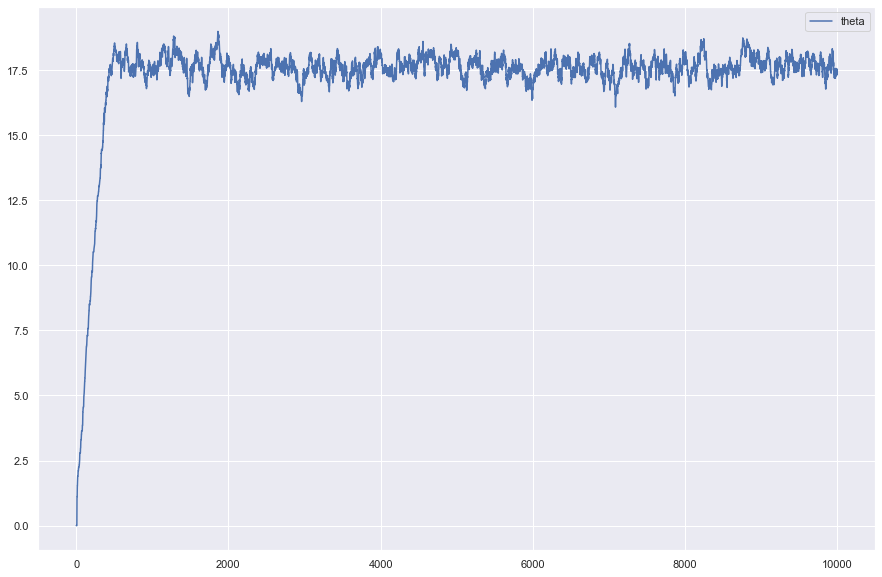

In [45]:
pd.DataFrame(MCMC_results, columns=['theta']).plot(figsize = (15,10))

In [46]:
pd.DataFrame(MCMC_results, columns=['theta']).loc[1000:,].describe()

,theta
count,9001.000000
mean,17.615457
std,0.392836
min,16.077655
25%,17.369795
50%,17.619149
75%,17.884017
max,18.986132


In [47]:
1/epi_augment.delta_t.mean() # answer above matches! 

17.748809334867772

## Bayesian Inference 

With the simple case solved, let's move on to the multivariate scheme required to get both parameters of interest (namely $\theta = (\beta, \gamma)$).

In [52]:
# try to back out the overall event rate in the population: i.e. run MCMC for an exponential distribution
def epidemic_MCMC(data, init):

    def metropolisHastings(init, logLik, rprop, dprior, iters=10001):
        # initialize matrix to store results
        mat = np.zeros(shape=(iters, len(init)))
        mat[0, :] = init

        theta = init

        # compute initial logLik
        ll_main = logLik(mat[0, :])

        # run the MCMC for iters many iterations

        for ii in range(iters):
            # propose new parameters
            theta_proposed = rprop(theta)
            # check if proposal is a valid one

            ll_proposed = logLik(theta_proposed)

            # compute the (log) acceptance probability

            a = ll_proposed-ll_main + \
                dprior(theta_proposed) - dprior(theta)
            # print(f"proposal, {theta_proposed}. alpha {a}.")

            if (np.log(stats.uniform(0, 1).rvs()) < a):
                # print('accept')
                theta = theta_proposed
                ll_main = ll_proposed

                # store the result
                mat[ii, :] = theta
            else:
                # print('reject')
                mat[ii, :] = mat[ii-1, :]

        print('MCMC done!')

        return mat

    def proposal_denisty(parameters):
        return stats.norm(parameters, 0.1).rvs()

    def prior_density(parameters):
        return np.sum(stats.gamma.logpdf(parameters, 3, loc=0, scale=1))

    def logLik(parameters):
        # this is the only model specific function!
        # rest will adapt to the size of the parameters but this one has to be specified manually
        return (data.infection_event.sum() - 1) * np.log(parameters[0]) + \
            data.removal_event.sum() * np.log(parameters[1]) - \
            np.sum((parameters[0] * data.I * data.R/1000 +
                   parameters[1] * data.R)*data.delta_t)

    return metropolisHastings(init=init,
                              logLik=logLik,
                              rprop=proposal_denisty,
                              dprior=prior_density)


MCMC_results2 = epidemic_MCMC(data=epi_augment, init=[0.1, 0.1])

/var/folders/_q/07k1y14x087brt3tmd2bs1740000gn/T/ipykernel_19753/3479102102.py:54: RuntimeWarning: invalid value encountered in log
  data.removal_event.sum() * np.log(parameters[1]) - \
/var/folders/_q/07k1y14x087brt3tmd2bs1740000gn/T/ipykernel_19753/3479102102.py:53: RuntimeWarning: invalid value encountered in log
  return (data.infection_event.sum() - 1) * np.log(parameters[0]) + \


MCMC done!


array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

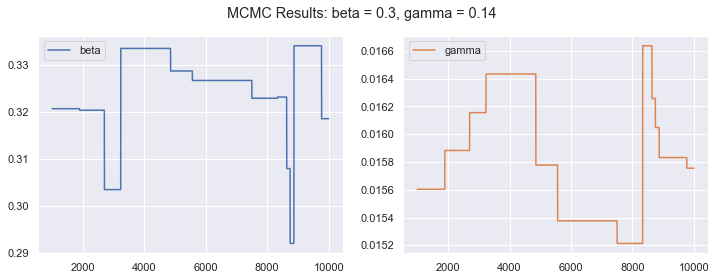

In [56]:
pd.DataFrame(MCMC_results2, columns=['beta', 'gamma']).loc[1000:,:].plot(
    title='MCMC Results: beta = 0.3, gamma = 0.14',
    figsize=(12, 4),
    subplots=True,
    layout=(1, 2))

array([[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>]],
      dtype=object)

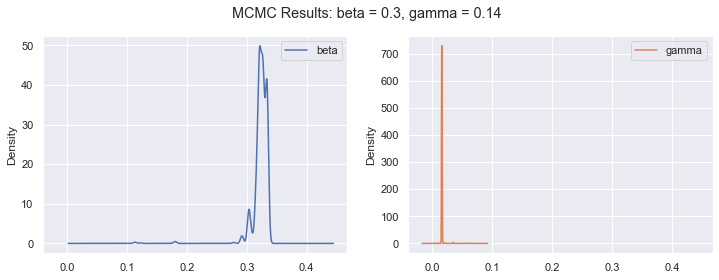

In [54]:
pd.DataFrame(MCMC_results2, columns=['beta', 'gamma']).plot(
    title='MCMC Results: beta = 0.3, gamma = 0.14',
    kind = 'kde',
    figsize=(12, 4),
    subplots=True,
    layout=(1, 2))

In [55]:
pd.DataFrame(MCMC_results2, columns=['beta', 'gamma']).describe()

,beta,gamma
count,10001.000000,10001.000000
mean,0.323042,0.015890
std,0.016290,0.001991
min,0.112538,0.010154
25%,0.320366,0.015377
50%,0.326716,0.015778
75%,0.333549,0.016155
max,0.334121,0.064949


Comments: 
- Beta is correctly estimated with a value of ~0.3, more iterations would push this in the right direction 
- Gamma is quite far off the correct value 
- a **big** concern is the bouncing between 0 and some other values that both parameters exhibit 
    - could this be because of the indicator columns in the data? When an infection event happens, the sampler forces the removal rate to 0 and vice versa? 
